In [1]:
library(keras)
library(tensorflow)

library(OpenImageR)
library(imager)
library(EBImage)

library(tidyverse)
library(rsample)
library(readxl)
ggplot2::theme_set(theme_bw())

Loading required package: magrittr


Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image



Attaching package: ‘EBImage’


The following objects are masked from ‘package:imager’:

    channel, dilate, display, erode, resize, watershed


The following objects are masked from ‘package:OpenImageR’:

    readImage, writeImage


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ imager::add()       masks magrittr::add()
✖ stringr::boundary() masks imager::boundary()
✖ dplyr::com

## 데이터 로드

In [9]:
Covid_meta <- read_xlsx("../input/covid19-radiography-dataset/COVID.metadata.xlsx",
                                sheet = "Sheet1") 
Lung_meta <- read_xlsx("../input/covid19-radiography-dataset/Lung_Opacity.metadata.xlsx",
                        sheet = "Sheet1") 
Normal_meta <- read_xlsx("../input/covid19-radiography-dataset/Normal.metadata.xlsx",
                        sheet = "Sheet1") 
Viral_meta <- read_xlsx("../input/covid19-radiography-dataset/Viral Pneumonia.metadata.xlsx",
                        sheet = "Sheet1") 

In [10]:
Covid_img <- file.path("../input/covid19-radiography-dataset/COVID/images") %>%
  list.files(full.names = T)
Lung_img <- file.path("../input/covid19-radiography-dataset/Lung_Opacity/images") %>%
  list.files(full.names = T)
Normal_img <- file.path("../input/covid19-radiography-dataset/Normal/images") %>%
  list.files(full.names = T)
Viral_img <- file.path("../input/covid19-radiography-dataset/Viral Pneumonia/images") %>%
  list.files(full.names = T)

In [11]:
classes = c("COVID", "Lung_Opacity", "Normal", "Viral Pneumonia")
Covid_meta <- Covid_meta %>% mutate(class = rep(classes[1], nrow(Covid_meta))) %>%
  arrange(.['FILE NAME'])
Lung_meta <- Lung_meta %>% mutate(class = rep(classes[2], nrow(Lung_meta))) %>%
  arrange(.['FILE NAME'])
Normal_meta <- Normal_meta %>% mutate(class = rep(classes[3], nrow(Normal_meta))) %>%
  arrange(.['FILE NAME'])
Viral_meta <- Viral_meta %>% mutate(class = rep(classes[4], nrow(Viral_meta))) %>%
  arrange(.['FILE NAME'])

In [17]:
df <- rbind(Covid_meta, Lung_meta) %>% rbind(Normal_meta) %>% rbind(Viral_meta)
df$class <- df$class %>% as.factor()

## Ratio of Classes in Dataset

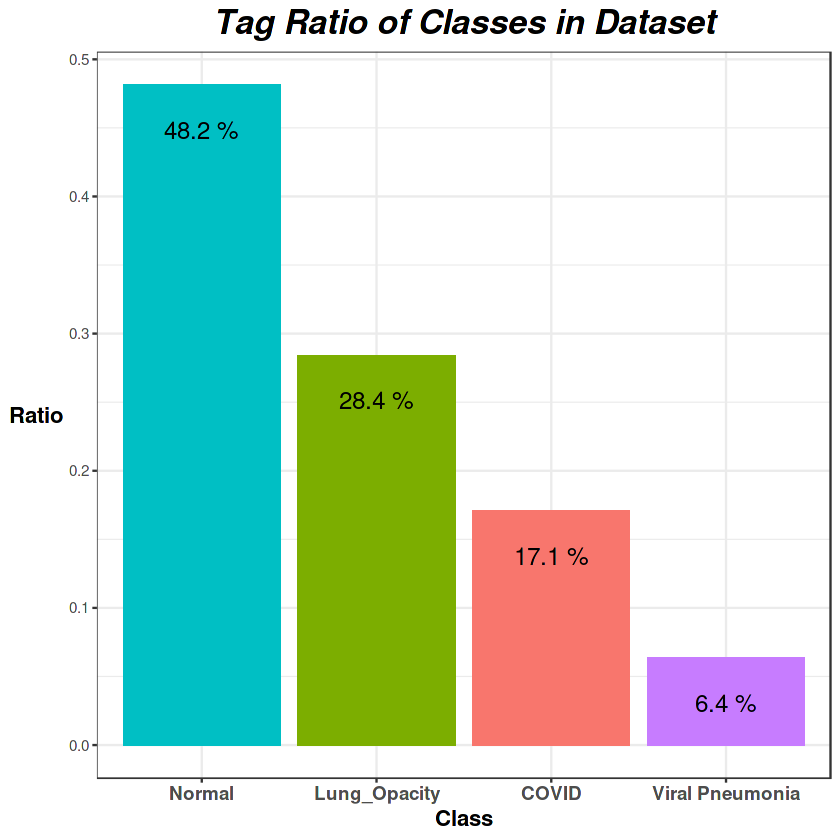

In [18]:
df %>% group_by(class) %>% count() %>% mutate(ratio = n / nrow(df)) %>% ungroup() %>%
    ggplot(aes(fct_reorder(class, -ratio), ratio, fill = class)) + geom_col() + 
    ggtitle("Tag Ratio of Classes in Dataset") + xlab("Class") + ylab("Ratio") + 
    geom_text(aes(label = paste((table(df$class) %>% prop.table() %>% round(3)) * 100, "%")), vjust = 3, size = 5) + 
    theme(legend.position = "none",
        axis.text.x = element_text(size = 11, face = "bold"),
        axis.title.y = element_text(size = 13, face = "bold", angle = 0, vjust = 0.5),
        axis.title.x = element_text(size = 13, face = "bold"),
        plot.title = element_text(size = 20, hjust = 0.5, face = "bold.italic"))

## 데이터 확인
- 이미지는 299 X 299의 픽셀 크기를 가짐

In [19]:
dim(image_load(Covid_img[1]) %>% image_to_array())

Loaded Tensorflow version 2.6.3



[1] 299 299   3

### Covid Images

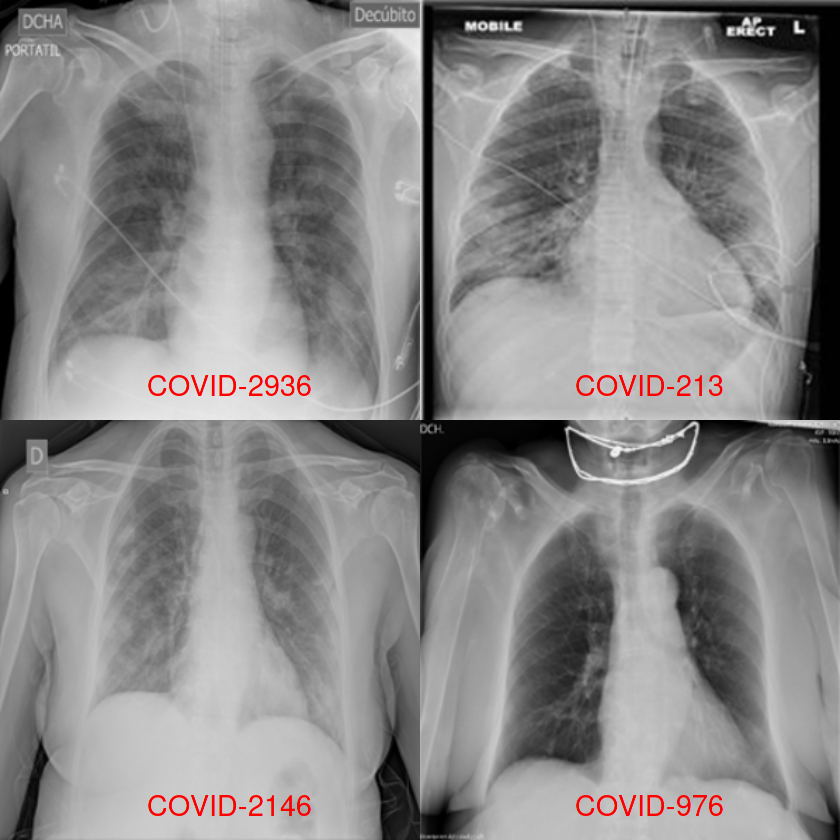

In [91]:
par(mfrow = c(2, 2))
for (i in sample(length(Covid_img),4)) {    
  readImage(Covid_img[i]) %>% resize(w = 299, h = 299) %>% 
    Image() %>% plot() %>% title(xlab = paste0(Covid_meta[i,1]), cex.lab = 1.7, col.lab = "red") 
}

## Lung Opacity Images

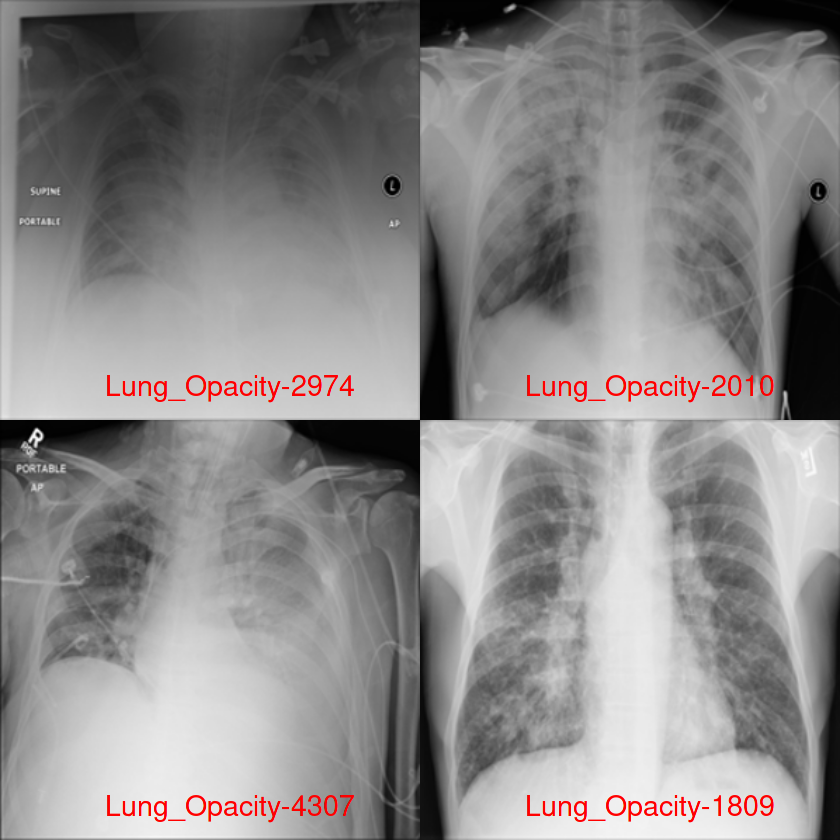

In [21]:
par(mfrow = c(2,2))
for (i in sample(length(Lung_img),4)) {    
  readImage(Lung_img[i]) %>% resize(w = 299, h = 299) %>% 
    Image() %>% plot() %>% title(xlab = paste0(Lung_meta[i,1]), cex.lab = 1.7, col.lab = "red") 
}

### Normal Images

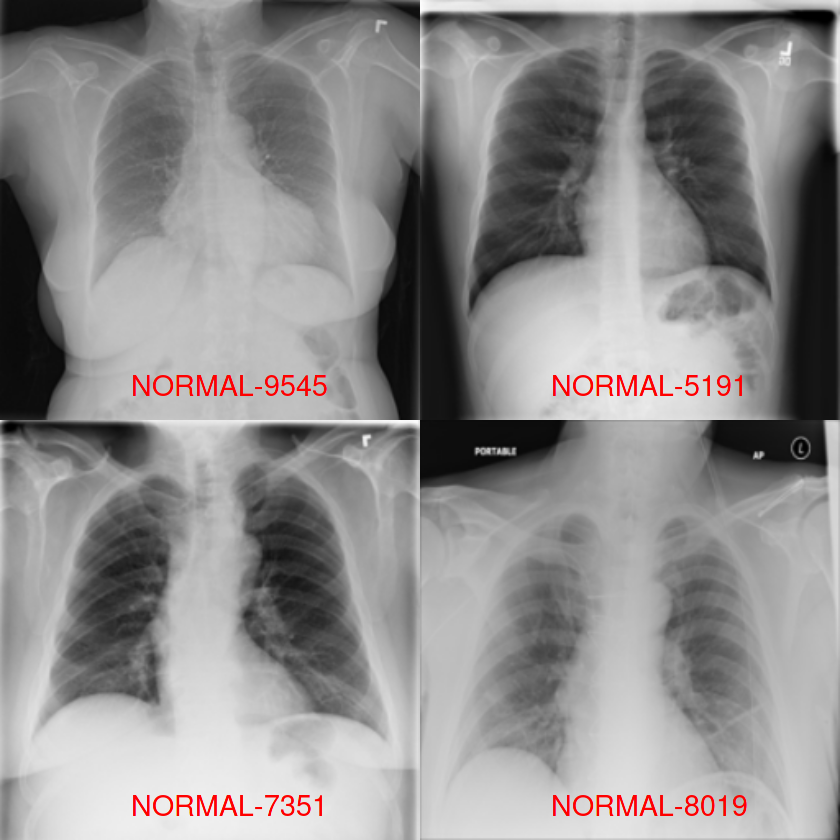

In [22]:
par(mfrow = c(2,2))
for (i in sample(length(Normal_img),4)) {    
  readImage(Normal_img[i]) %>% resize(w = 256, h = 256) %>% 
    Image() %>% plot() %>% title(xlab = paste0(Normal_meta[i,1]), cex.lab = 1.7, col.lab = "red") 
}

### Viral Pneumonia Images

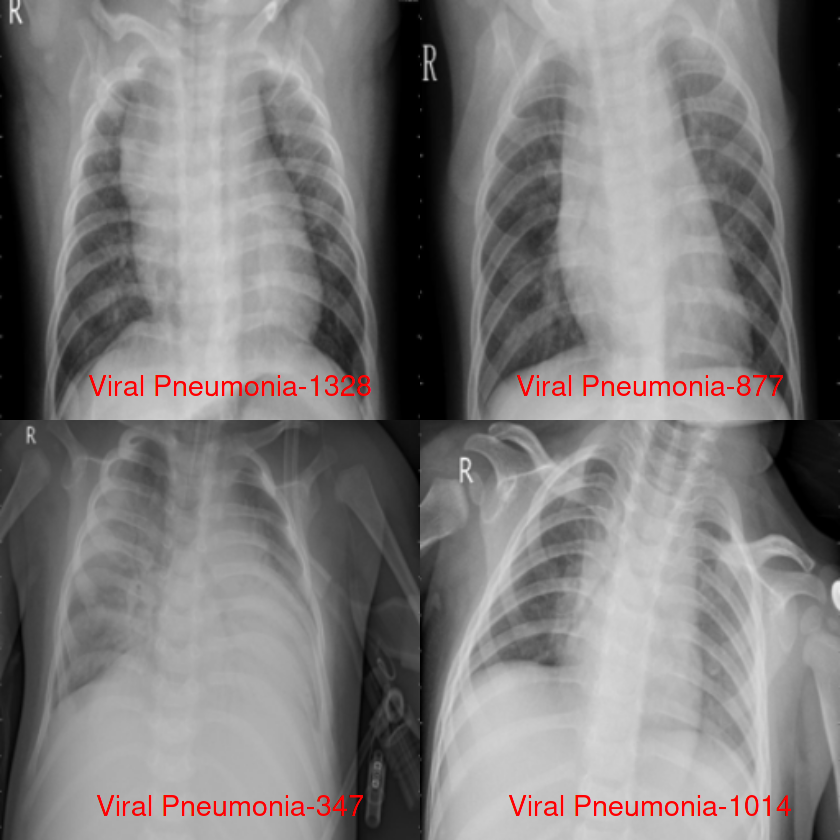

In [23]:
par(mfrow = c(2,2))
for (i in sample(length(Viral_img),4)) {    
  readImage(Viral_img[i]) %>% resize(w = 256, h = 256) %>% 
    Image() %>% plot() %>% title(xlab = paste0(Viral_meta[i, 1]), cex.lab = 1.7, col.lab = "red") 
}

## Create Generator

In [24]:
(classes) ; length(classes)
batch_size = 32
path = "../input/covid19-radiography-dataset"

[1] "COVID"           "Lung_Opacity"    "Normal"          "Viral Pneumonia"

[1] 4

In [25]:
train_datagen1 <- image_data_generator(
    rescale = 1/255,
    validation_split = 0.2,
)

In [26]:
train_generator1 <- flow_images_from_directory(
    directory = path,
    generator = train_datagen1,
    target_size = c(299, 299),
    batch_size = batch_size,
    class_mode = "categorical",
    classes = classes,
    shuffle = TRUE,
    color_mode = "grayscale",
    subset = "training"
)

In [27]:
val_generator1 <- flow_images_from_directory(
    directory = path,
    generator = train_datagen1,
    target_size = c(299, 299),
    batch_size = batch_size,
    class_mode = "categorical",
    classes = classes,
    shuffle = FALSE,
    color_mode = "grayscale",
    subset = "validation"
)

In [32]:
(train_length1 <- train_generator1$classes %>% length)
(val_length <- val_generator1$classes %>% length)

[1] 16933

[1] 4232

## Model Creation & Fit

In [34]:
model <- keras_model_sequential() %>%
    layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = 'relu', 
                  padding = "same", input_shape = c(299, 299, 1)) %>%
    layer_batch_normalization() %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = 2, padding = "same") %>%

    layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = 'relu',
                 padding = "same") %>%
    layer_batch_normalization() %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = 2, padding = "same") %>%

    layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = 'relu',
                 padding = "same") %>%
    layer_batch_normalization() %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = 2, padding = "same") %>%

    layer_dropout(rate = 0.5)

In [35]:
model %>% layer_flatten() %>%
    layer_dense(units = 256, activation = 'relu') %>%

    layer_dropout(rate = 0.5) %>%

    layer_dense(units = 128, activation = "relu") %>%

    layer_dense(units = 4,activation = 'softmax')

In [36]:
model %>%
  compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizer_rmsprop(),
    metrics = 'accuracy'
  )

In [37]:
summary(model)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_2 (Conv2D)                   (None, 299, 299, 32)            320         
________________________________________________________________________________
batch_normalization_2 (BatchNormali (None, 299, 299, 32)            128         
________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)      (None, 150, 150, 32)            0           
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 150, 150, 64)            18496       
________________________________________________________________________________
batch_normalization_1 (BatchNormali (None, 150, 150, 64)            256         
________________________________________________________________________________
max_pool

In [40]:
reduce_lr <- callback_reduce_lr_on_plateau(monitor = "val_loss", factor = 0.05)
early_stop <- callback_early_stopping(patience = 10, restore_best_weights = TRUE)
checkpoint <- callback_model_checkpoint("checkpoints.h5", save_best_only = TRUE)

In [45]:
history1 <- model %>% fit(
    train_generator1,
    validation_data = val_generator1,
    batch_size = batch_size,
    callbacks = list(reduce_lr, early_stop, checkpoint),
    epochs = 100,
    verbose = FALSE
)

## Model Evaluation

In [46]:
history1


Final epoch (plot to see history):
        loss: 0.1517
    accuracy: 0.9528
    val_loss: 0.459
val_accuracy: 0.8748
          lr: 0.001 

`geom_smooth()` using formula 'y ~ x'



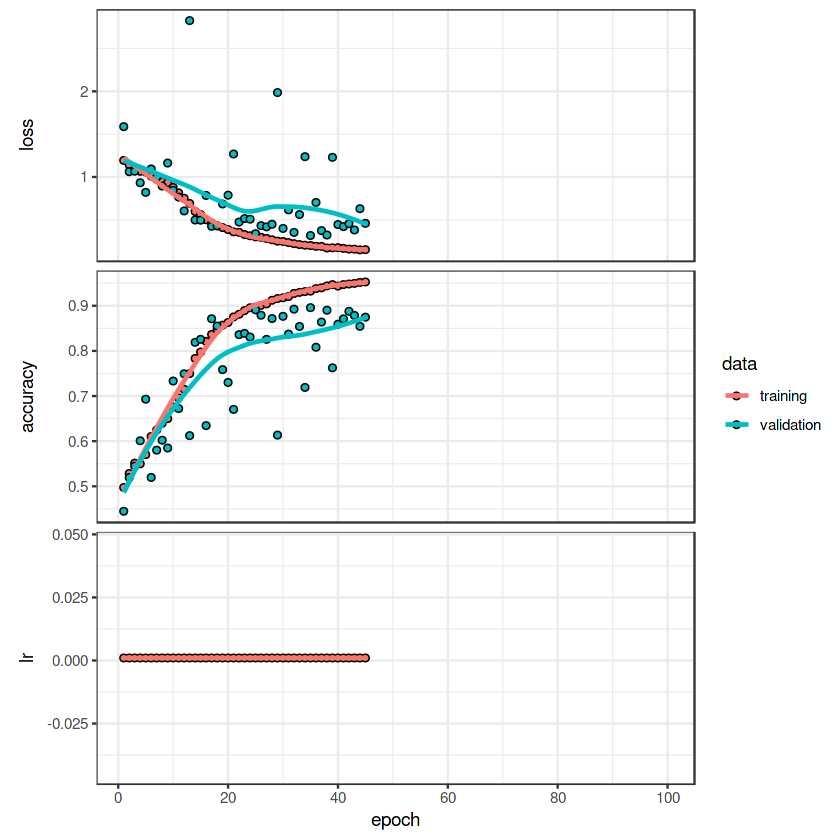

In [47]:
plot(history1)

In [48]:
model %>% evaluate(val_generator1)

loss accuracy 
0.316580 0.895794

In [49]:
pred1 <- model %>% predict(val_generator1) %>% 
    ramify::argmax()
pred1 <- (pred1 - 1) %>% as.factor()

In [50]:
truth <- val_generator1$classes %>% factor()
(levels(truth) <- classes)
(levels(pred1) <- classes)

[1] "COVID"           "Lung_Opacity"    "Normal"          "Viral Pneumonia"

[1] "COVID"           "Lung_Opacity"    "Normal"          "Viral Pneumonia"

In [54]:
caret::confusionMatrix(pred1, truth)

Confusion Matrix and Statistics

                 Reference
Prediction        COVID Lung_Opacity Normal Viral Pneumonia
  COVID             664           16     13               3
  Lung_Opacity       25         1021    148               2
  Normal             32          165   1864              22
  Viral Pneumonia     2            0     13             242

Overall Statistics
                                          
               Accuracy : 0.8958          
                 95% CI : (0.8862, 0.9048)
    No Information Rate : 0.4816          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.8399          
                                          
 Mcnemar's Test P-Value : 0.01713         

Statistics by Class:

                     Class: COVID Class: Lung_Opacity Class: Normal
Sensitivity                0.9184              0.8494        0.9146
Specificity                0.9909              0.9422        0.9002
Pos Pr

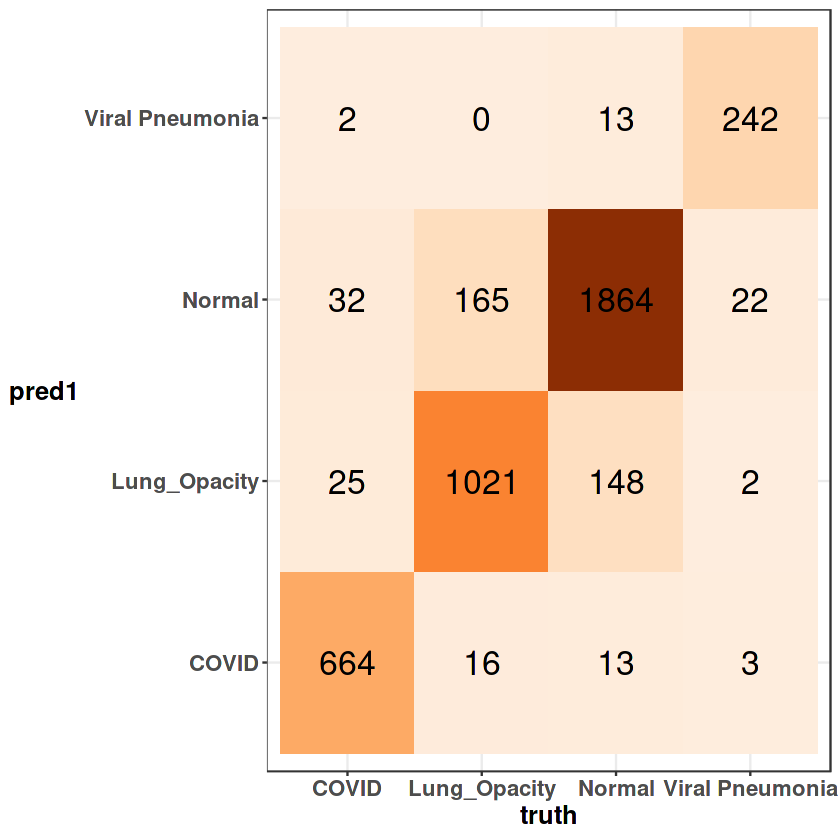

In [55]:
table(truth, pred1) %>% as.tibble() %>% 
    ggplot(aes(truth, pred1, fill = n)) + geom_tile() + 
    geom_text(aes(label = n), size = 7) + 
    theme(legend.position = "none",
         axis.title.x = element_text(size = 15, face = "bold"),
         axis.title.y = element_text(size = 15, face = "bold",
                                    angle = 0, vjust = 0.5),
        axis.text = element_text(size = 13, face = "bold")) +
    scale_fill_distiller(palette="Oranges", direction=1) 

### Image Augmentation

In [66]:
sample_gen <- image_data_generator(
    rescale = 1/255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = TRUE,
    fill_mode = "nearest"
)

In [94]:
sample_aug <- flow_images_from_data(
    sample_img,
    generator = sample_gen,
    batch_size = 1
)

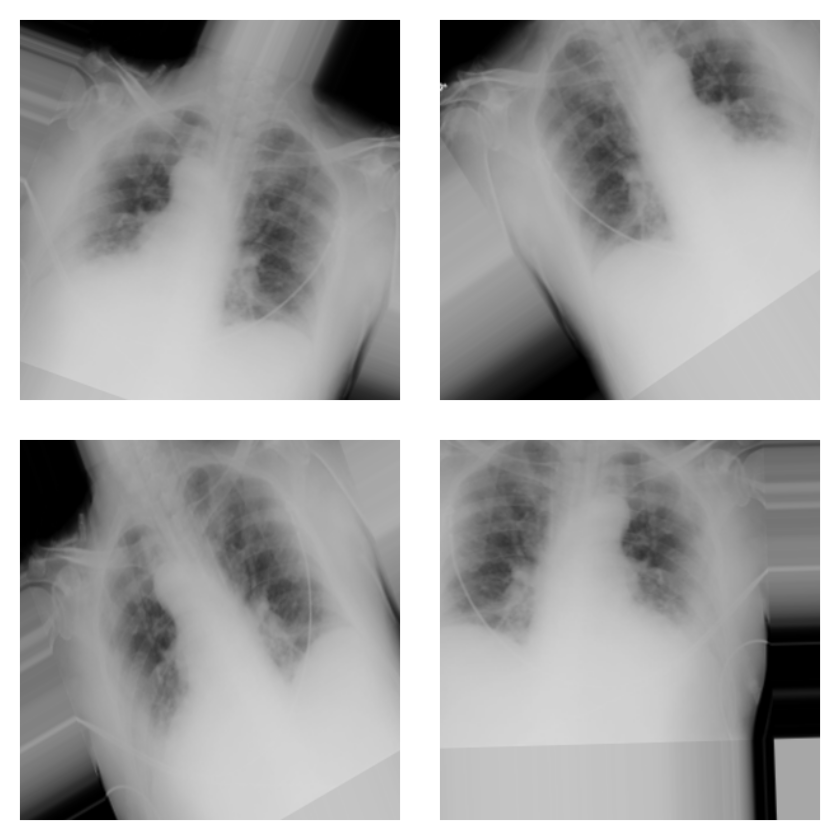

In [96]:
sample_img1 <- image_load(Covid_img[1]) %>% 
    image_to_array() %>% array_reshape(c(1, 299, 299, 3))

par(mfrow = c(2,2), pty = 's', mar = c(1, 0, 1, 0))
for (i in 1:4) {
  aug_img <- generator_next(sample_aug)
  plot(as.raster(aug_img[1, , , ]))
}

### Fit Augmented Images

In [108]:
train_datagen2 <- image_data_generator(
    rescale = 1/255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = TRUE,
    fill_mode = "nearest",
    validation_split = 0.2
)

In [109]:
train_generator2 <- flow_images_from_directory(
    directory = path,
    generator = train_datagen2,
    target_size = c(299, 299),
    batch_size = batch_size,
    class_mode = "categorical",
    classes = classes,
    shuffle = TRUE,
    color_mode = "grayscale",
    subset = "training"
)

In [111]:
(train_length2 <- train_generator2$classes %>% length)
val_length

[1] 16933

[1] 4232

In [114]:
history2 <- model %>% fit(
    train_generator2,
    validation_data = val_generator1,
    batch_size = batch_size,
    callbacks = list(reduce_lr, early_stop, checkpoint),
    epochs = 100,
    verbose = FALSE
)


Final epoch (plot to see history):
        loss: 0.6887
    accuracy: 0.7342
    val_loss: 0.4499
val_accuracy: 0.8667
          lr: 0.00005 

`geom_smooth()` using formula 'y ~ x'



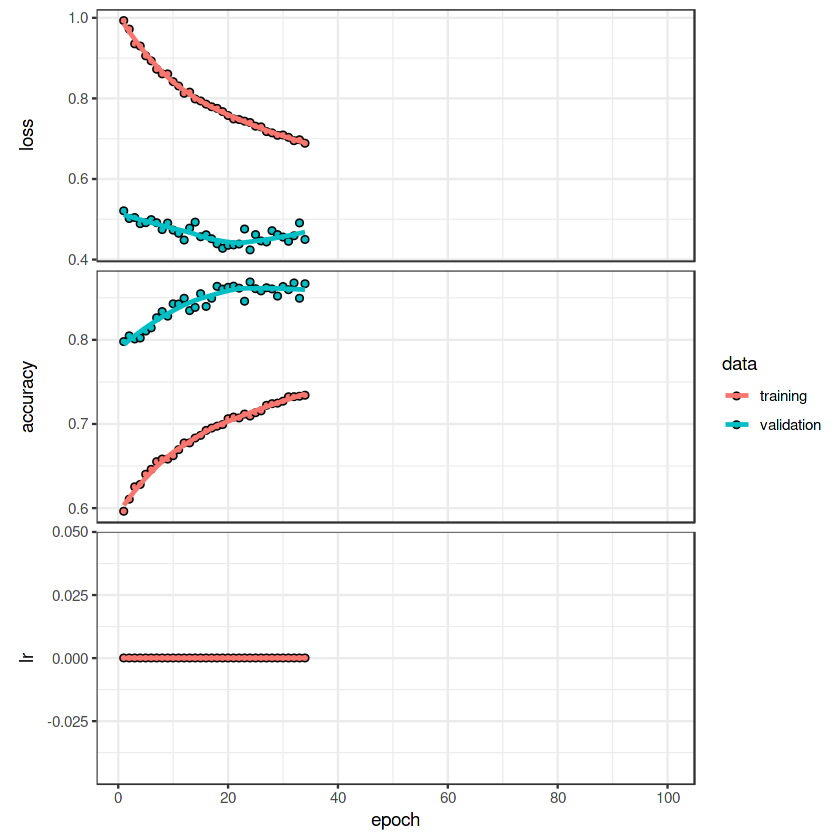

In [115]:
history2
plot(history2)

In [116]:
model %>% evaluate(val_generator1)

loss  accuracy 
0.4240043 0.8688563

In [117]:
pred2 <- model %>% predict(val_generator1) %>% 
    ramify::argmax()
pred2 <- (pred2 - 1) %>% as.factor()

In [125]:
(levels(pred2) <- classes)

[1] "COVID"           "Lung_Opacity"    "Normal"          "Viral Pneumonia"

In [126]:
caret::confusionMatrix(pred2, truth)

Confusion Matrix and Statistics

                 Reference
Prediction        COVID Lung_Opacity Normal Viral Pneumonia
  COVID             549           26     22               0
  Lung_Opacity       72          987    102               0
  Normal            101          189   1889              17
  Viral Pneumonia     1            0     25             252

Overall Statistics
                                          
               Accuracy : 0.8689          
                 95% CI : (0.8583, 0.8789)
    No Information Rate : 0.4816          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7963          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: COVID Class: Lung_Opacity Class: Normal
Sensitivity                0.7593              0.8211        0.9269
Specificity                0.9863              0.9426        0.8601
Pos Pr

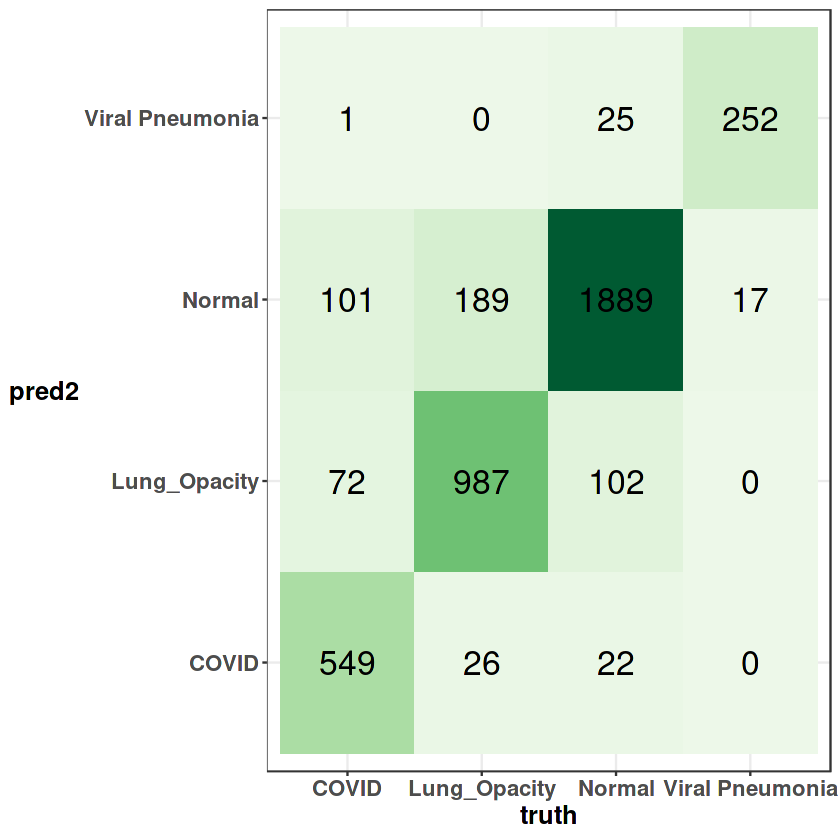

In [134]:
table(truth, pred2) %>% as.tibble() %>% 
    ggplot(aes(truth, pred2, fill = n)) + geom_tile() + 
    geom_text(aes(label = n), size = 7) + 
    theme(legend.position = "none",
         axis.title.x = element_text(size = 15, face = "bold"),
         axis.title.y = element_text(size = 15, face = "bold",
                                    angle = 0, vjust = 0.5),
        axis.text = element_text(size = 13, face = "bold")) +
    scale_fill_distiller(palette="Greens", direction = 1) 